# Homework 3: Augmented Reality with Planar Homographies

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q2**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Q1 Preliminaries

## Q1.1 The Direct Linear Transform


### Q1.1.1 (3 points)

How many degrees of freedom does **h** have?

---

8

---

### Q1.1.2 (2 points)

How many point pairs are required to solve **h**?

---

At least 4

---

### Q1.1.3 (5 points)

Derive $\textbf{A}_i$

---

$\mathbf{A}_i=\begin{bmatrix}-x_2^i & -y_2^i & -1 & 0 & 0 & 0 & x_1^ix_2^i & x_1^iy_2^i & x_1^i \\ 0 & 0 & 0 & -x_2^i & -y_2^i & -1 & y_1^ix_2^i & y_1^iy_2^i & y_1^i \\ 0 & 0 & 0 & 0 & 0 & 0 & x_2^i & y_2^i & 1\end{bmatrix}$

---

### Q1.1.4 (5 points)

What will be the trivial solution for **h**? Is the matrix **A** full rank? Why/Why not? What impact will it have on the singular values (i.e. eigenvalues of $\textbf{A}^T\textbf{A}$)?

---

1. A trival solution for $\mathbf{h}$ would be $\mathbf{h}=\begin{bmatrix}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}^T$. \\
2. The matrix $\mathbf{A}$ is not full rank because it represents a system of linear equations where each equation is essentially a linear combination of the others. \\
3. The impact on the singular values (eigenvalues of $\mathbf{A}^T\mathbf{A}$) is that at least one singular value will be close to zero, indicating that the matrix is close to being singular.

---

## Q1.2 Homography Theory Questions

### Q1.2.1 (5 points)

Prove that there exists a homography **H** that satisfies $\textbf{x}_1 ≡ \textbf{Hx}_2$, given two cameras separated by a pure rotation.

---

For pure rotation between cameras, $\mathbf{H} = \mathbf{K}_1^{-1}\mathbf{K}_2\begin{bmatrix}R & 0\end{bmatrix}$. This $\mathbf{H}$ satisfies $\mathbf{x}_1 \equiv \mathbf{H}\mathbf{x}_2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ are the coordinates of the same 3D point observed in two different camera frames.

---

### Q1.2.2 (5 points):

Show that $\textbf{H}^2$ is the homography corresponding to a rotation of 2$\theta$.

---

Since $\mathbf{H}$ is a transformation matrix representing rotation, applying it twice corresponds to performing the rotation twice, which effectively doubles the angle of rotation, resulting in a rotation of $2\theta$. Hence, $\mathbf{H}^2$ corresponds to a rotation of $2\theta$.

---

# Initialization

Run the following code to import the modules you'll need.

In [8]:
import os
import numpy as np
import cv2
import skimage.color
import pickle
from matplotlib import pyplot as plt
import scipy
from skimage.util import montage
import time

PATCHWIDTH = 9

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def write_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

def briefMatch(desc1,desc2,ratio):

    matches = skimage.feature.match_descriptors(desc1,desc2,
                                                'hamming',
                                                cross_check=True,
                                                max_ratio=ratio)
    return matches

def plotMatches(img1,img2,matches,locs1,locs2):

    fig, ax = plt.subplots(nrows=1, ncols=1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    skimage.feature.plot_matches(ax,img1,img2,locs1,locs2,
                                 matches,matches_color='r',only_matches=True)
    plt.show()
    return

def makeTestPattern(patchWidth, nbits):

    np.random.seed(0)
    compareX = patchWidth*patchWidth * np.random.random((nbits,1))
    compareX = np.floor(compareX).astype(int)
    np.random.seed(1)
    compareY = patchWidth*patchWidth * np.random.random((nbits,1))
    compareY = np.floor(compareY).astype(int)

    return (compareX, compareY)

def computePixel(img, idx1, idx2, width, center):

    halfWidth = width // 2
    col1 = idx1 % width - halfWidth
    row1 = idx1 // width - halfWidth
    col2 = idx2 % width - halfWidth
    row2 = idx2 // width - halfWidth
    return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0

def computeBrief(img, locs):

    patchWidth = 9
    nbits = 256
    compareX, compareY = makeTestPattern(patchWidth,nbits)
    m, n = img.shape

    halfWidth = patchWidth//2

    locs = np.array(list(filter(lambda x: halfWidth <= x[0] < m-halfWidth and halfWidth <= x[1] < n-halfWidth, locs)))
    desc = np.array([list(map(lambda x: computePixel(img, x[0], x[1], patchWidth, c), zip(compareX, compareY))) for c in locs])

    return desc, locs

def corner_detection(img, sigma):

    # fast method
    result_img = skimage.feature.corner_fast(img, n=PATCHWIDTH, threshold=sigma)
    locs = skimage.feature.corner_peaks(result_img, min_distance=1)
    return locs

def loadVid(path):

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name

    cap = cv2.VideoCapture(path)

    # get fps, width, and height
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Append frames to list
    frames = []

    # Check if camera opened successfully
    if cap.isOpened()== False:
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            #Store the resulting frame
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    frames = np.stack(frames)

    return frames, fps, width, height

# Download data

Download the required data and setup the results directory. If running on colab, DATA_PARENT_DIR must be <br> DATA_PARENT_DIR = '/content/' <br> <br> Otherwise, use the local directory of your choosing. Data will be downloaded to DATA_PARENT_DIR/hw3_data and a subdirectory DATA_PARENT_DIR/results will be created.

In [9]:
# Only change this if you are running locally
# Default on colab: DATA_PARENT_DIR = '/content/'

# Data will be downloaded to DATA_PARENT_DIR/hw3_data
# A subdirectory DATA_PARENT_DIR/results will be created

DATA_PARENT_DIR = '/content/'

if not os.path.exists(DATA_PARENT_DIR):
  raise RuntimeError('DATA_PARENT_DIR does not exist: ', DATA_PARENT_DIR)

RES_DIR = os.path.join(DATA_PARENT_DIR, 'results')
if not os.path.exists(RES_DIR):
  os.mkdir(RES_DIR)
  print('made directory: ', RES_DIR)


#paths different files are saved to
# OPTIONAL:
# feel free to change if funning locally
ROT_MATCHES_PATH = os.path.join(RES_DIR, 'brief_rot_test.pkl')
ROT_INV_MATCHES_PATH = os.path.join(RES_DIR, 'ec_brief_rot_inv_test.pkl')
AR_VID_FRAMES_PATH = os.path.join(RES_DIR, 'q_3_1_frames.npy')
AR_VID_FRAMES_EC_PATH = os.path.join(RES_DIR, 'q_3_2_frames.npy')

HW3_SUBDIR = 'hw3_data'
DATA_DIR = os.path.join(DATA_PARENT_DIR, HW3_SUBDIR)
ZIP_PATH = DATA_DIR + '.zip'
if not os.path.exists(DATA_DIR):
  !wget 'https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip' -O $ZIP_PATH
  !unzip -qq $ZIP_PATH -d $DATA_PARENT_DIR

# Q2 Computing Planar Homographies

## Q2.1 Feature Detection and Matching

### Q2.1.1 (5 points):

How is the FAST detector different from the Harris corner detector that you've seen in the lectures? Can you comment on its computation performance compared to the Harris corner detector?

---

FAST detector, different from being based on the eigenvalues of the second moment matrix of the image gradient like Harris corner detector, it considers a circle of 16 pixels around the target pixel. It determines if the target is a corner based on whether there are n contiguous pixels in the circle that are all brighter than the intensity of target. Without computing the gradient, it is more computationally efficient than Harris corner detector but less robust to noise.

---

### Q2.1.2 (5 points):

How is the BRIEF descriptor different from the filterbanks you've seen in the lectures? Could you use any one of the those filter banks as a descriptor?

---

BRIEF descriptor use binary representation based on intensity comparisons, which is more efficient thant the filterbanks but captures less information comparatively. This leads to that filterbanks are more robust to variations in image conditions. \\
Yes, filterbanks like SIFT and HOG can also be used as descriptors. SIFT uses DoG while HOG computes gradient to realize the description.

---

### Q2.1.3 (5 points):

Describe how the Hamming distance and Nearest Neighbor can be used to match interest points with BRIEF descriptors. What benefits does the Hamming distance have over a more conventional Euclidean distance measure in our setting?

---

The character of Hamming distance is that it measures the number of discrepancies in the binary strings, which makes Hamming distance better for matching BRIEF discriptors than Euclidean distance since BRIEF creates a binary string for each point by comparing the intensities of pairs of pixels around interest point. \\
Nearest Neighbor search is used when descriptor in the second image find smallest Hamming distance after first image.

---

### Q2.1.4 (10 points):

#### Implement the function matchPics()

In [10]:
def matchPics(I1, I2, ratio, sigma):
    """
    Match features across images

    Input
    -----
    I1, I2: Source images (RGB or Grayscale uint8)
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector

    Returns
    -------
    matches: List of indices of matched features across I1, I2 [p x 2]
    locs1, locs2: Pixel coordinates of matches [N x 2]
    """

    # ===== your code here! =====

    # TODO: Convert images to GrayScale
    # Input images can be either RGB or Grayscale uint8 (0 -> 255). Both need
    # to be supported.
    # Input images must be converted to normalized Grayscale (0.0 -> 1.0)
    # skimage.color.rgb2gray may be useful if the input is RGB.
    if len(I1.shape) == 3:
        I1 = skimage.color.rgb2gray(I1)

    if len(I2.shape) == 3:
        I2 = skimage.color.rgb2gray(I2)

    # TODO: Detect features in both images
    locs1 = corner_detection(I1, sigma)
    locs2 = corner_detection(I2, sigma)

    # TODO: Obtain descriptors for the computed feature locations
    desc1, locs1 = computeBrief(I1, locs1)
    desc2, locs2 = computeBrief(I2, locs2)


    # TODO: Match features using the descriptors
    matches = briefMatch(desc1, desc2, ratio)

    # ==== end of code ====

    return matches, locs1, locs2

#### Implement the function displayMatched

In [11]:
def displayMatched(I1, I2, ratio, sigma):
    """
    Displays matches between two images

    Input
    -----
    I1, I2: Source images
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    """

    print('Displaying matches for ratio: ', ratio, ' and sigma: ', sigma)

    # ===== your code here! =====
    # TODO: Use matchPics and plotMatches to visualize your results
    matches, locs1, locs2 = matchPics(I1, I2, ratio, sigma)
    plotMatches(I1, I2, matches, locs1, locs2)
    # ==== end of code ====


#### Visualize the matches

Use the cell below to visualize the matches. The resulting figure should look similar (but not necessarily identical) to Figure 2.

Feel free to play around with the images and parameters. Please use the original images when submitting the report.

Figure 2 parameters:

*   image1_name = "cv_cover.jpg"
*   image1_name = "cv_desk.png"
*   ratio = 0.7
*   sigma = 0.15

Displaying matches for ratio:  0.7  and sigma:  0.15


<ipython-input-8-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


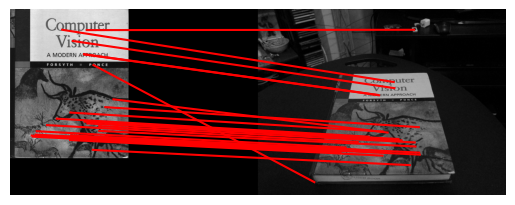

In [12]:
# Feel free to play around with these parameters
# BUT when submitting the report use the original images
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

displayMatched(image1, image2, ratio, sigma)

### Q2.1.5 (10 points):

Experiment with different sigma and ratio values. Conduct a small ablation study, and include the figures displaying the matched features with various parameters in your write-up. Explain the effect of these two paremeters respectively.

---

When keeping ratio constant and decrease sigma, the machings becomes less. However when sigma decrease to 0.10, high density of machings appears. Also when keeping sigma constant and increase ratio, more machings appears. But what is interesting is that when ratio = 0.65 and sigma = 0.15, all the machings are correct. The density is accpectable and no wrong machings are established.

---

Displaying matches for ratio:  0.7  and sigma:  0.2


<ipython-input-8-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


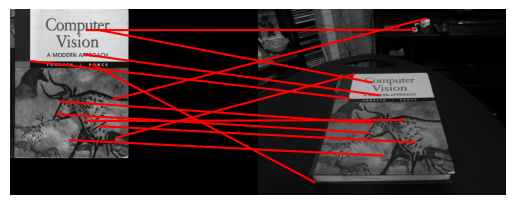

Displaying matches for ratio:  0.7  and sigma:  0.1


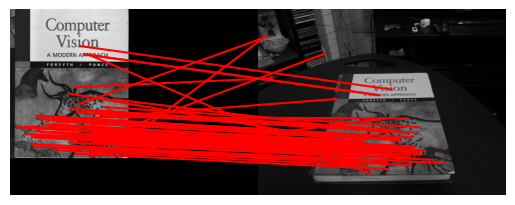

Displaying matches for ratio:  0.75  and sigma:  0.15


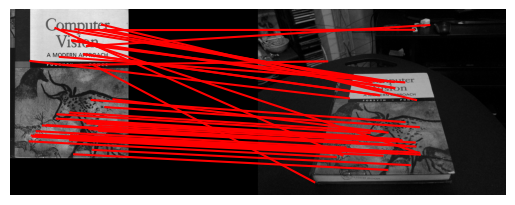

Displaying matches for ratio:  0.65  and sigma:  0.15


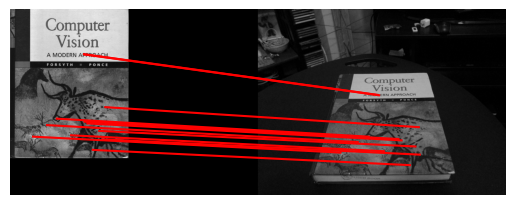

Displaying matches for ratio:  0.75  and sigma:  0.2


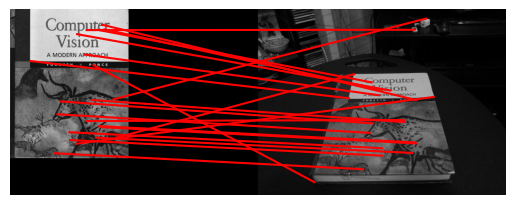

In [13]:
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# ===== your code here! =====
# Experiment with different sigma and ratio values.
# Use displayMatches to visualize.
# Include the matched feature figures in the write-up.

displayMatched(image1, image2, 0.7, 0.20)
displayMatched(image1, image2, 0.7, 0.10)
displayMatched(image1, image2, 0.75, 0.15)
displayMatched(image1, image2, 0.65, 0.15)
displayMatched(image1, image2, 0.75, 0.20)

# ==== end of code ====

### Q2.1.6 (10 points):

#### Implement the function briefRot

In [14]:
def briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Tests Brief with rotations.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    # Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # ===== your code here! =====
        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        rotated_image = scipy.ndimage.rotate(image, i, reshape = True)

        # TODO: Match features in images
        matches, locs1, locs2 = matchPics(image, rotated_image, ratio, sigma)

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        if (min_deg + i) % 60 == 0 and i <= max_deg:
            plotMatches(image, rotated_image, matches, locs1, locs2)

        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(len(matches))

        # ==== end of code ====

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    #plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)], weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

#### Visualize the matches under rotation

See debugging tips in handout.


0


<ipython-input-8-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


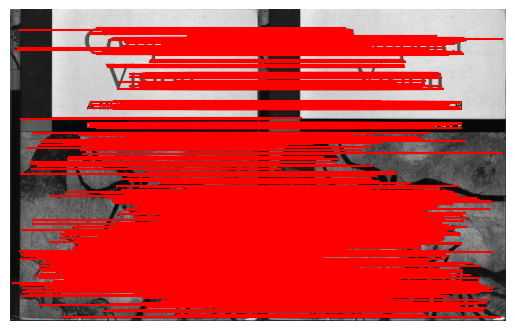

10
20
30
40
50
60


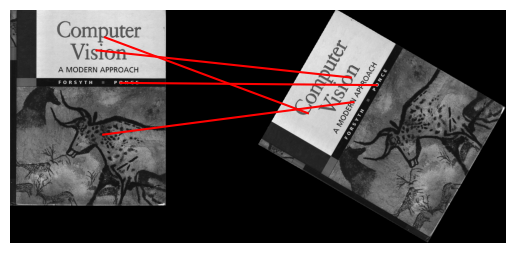

70
80
90
100
110
120


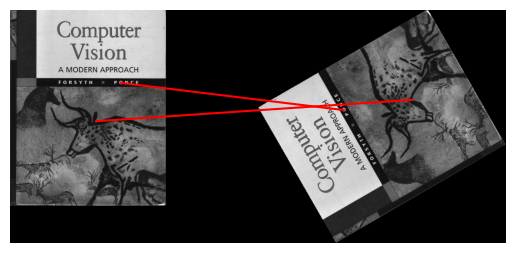

130
140
150
160
170
180


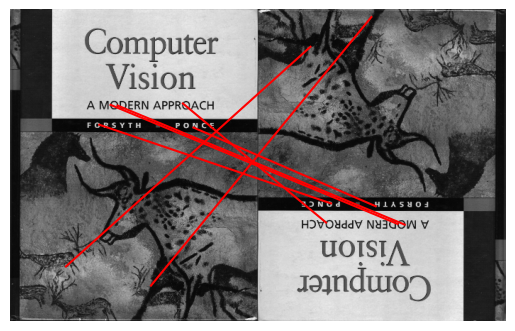

190
200
210
220
230
240


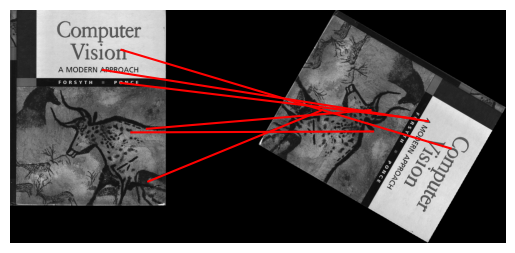

250
260
270
280
290
300


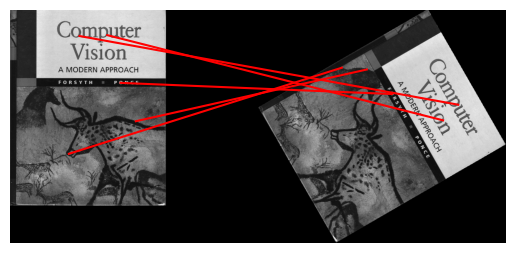

310
320
330
340
350


In [15]:
# defaults are:
# min_deg = 0
# max_deg = 360
# deg_inc = 10
# ratio = 0.7
# sigma = 0.15
# filename = 'cv_cover.jpg'

# Controls the rotation degrees
min_deg = 0
max_deg = 360
deg_inc = 10

# Brief feature descriptor and Fast feature detector paremeters
# (change these if you want to use different values)
ratio = 0.7
sigma = 0.15

# image to rotate and match
# (no need to change this but can if you want to experiment)
filename = 'cv_cover.jpg'

# Call briefRot
briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename)

#### Plot the histogram

See debugging tips in handout.

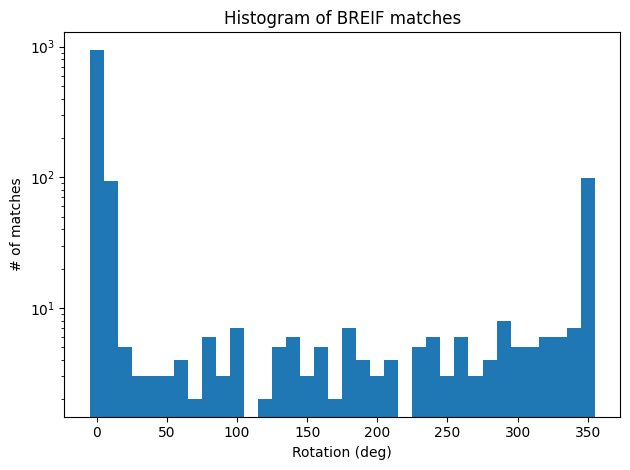

In [16]:
dispBriefRotHist()

---

Explain why you think the BRIEF descriptor behves this way: \\
 \\
The histogram of BRIEF matches has two distinct peaks at 0 degrees and 360 degrees, one smaller peak at 180 degrees. \\
When rotated, the amount of matches quickly drops because that BRIEF has limitation on rotation. The pixel intensity comparisons no longer align as the image is rorated. That is to say for rotation invariance, other filterbanks like SIFT or ORB will be more suitable as descriptors.

---

### Q2.1.7.1 (Extra Credit - 5 points):

Design a fix to make BRIEF more rotation invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.

In [21]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)
def compute_orientation(patch):
    """
    Compute the dominant orientation of a patch.
    """
    gy, gx = np.gradient(patch.astype('float32'))
    mag = np.sqrt(gx**2 + gy**2)
    ori = np.arctan2(gy, gx) * 180 / np.pi
    hist, _ = np.histogram(ori, bins=36, range=(-180, 180), weights=mag)
    dominant_orientation = np.argmax(hist) * 10 - 180
    return dominant_orientation

def rotate_patch(patch, angle):
    """
    Rotate the patch by the given angle.
    """
    return scipy.ndimage.rotate(patch, angle, reshape=False)

def get_patch(image, x, y, patch_size):
    """
    Extract a patch of size patch_size x patch_size centered at (x, y) from the image.
    """
    half_patch = patch_size // 2
    start_x = max(x - half_patch, 0)
    end_x = min(x + half_patch + 1, image.shape[1])
    start_y = max(y - half_patch, 0)
    end_y = min(y + half_patch + 1, image.shape[0])

    # If the patch goes out of the image boundaries, pad the image with zeros
    patch = np.zeros((patch_size, patch_size), dtype=image.dtype)
    patch_start_x = half_patch - min(x, half_patch)
    patch_start_y = half_patch - min(y, half_patch)
    patch_end_x = patch_start_x + end_x - start_x
    patch_end_y = patch_start_y + end_y - start_y

    patch[patch_start_y:patch_end_y, patch_start_x:patch_end_x] = image[start_y:end_y, start_x:end_x]
    return patch


def briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Rotation invariant Brief.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    locs = corner_detection(image, sigma)
    orientations = [compute_orientation(get_patch(image, x, y, PATCHWIDTH))
                    for (x, y) in locs]
    desc, locs = computeBrief(image, locs)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        rotated_image = scipy.ndimage.rotate(image, i, reshape=True)

        rotated_locs = corner_detection(rotated_image, sigma)

        rotated_orientations = [compute_orientation(get_patch(rotated_image, x, y, PATCHWIDTH))
                                for (x, y) in rotated_locs]
        rotated_desc = []
        for ((x, y), orientation) in zip(rotated_locs, rotated_orientations):
            patch = get_patch(rotated_image, x, y, PATCHWIDTH)
            rotated_patch = rotate_patch(patch, -orientation)
            brief_descriptor = computeBrief(rotated_patch, [(PATCHWIDTH//2, PATCHWIDTH//2)])[0]
            rotated_desc.append(brief_descriptor)

        matches = briefMatch(desc, np.array(rotated_desc), ratio)
        match_degrees.append(i)
        match_counts.append(len(matches))


        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        if (min_deg + i) % 60 == 0 and i <= max_deg:
            plotMatches(image, rotated_image, matches, locs, rotated_locs)

        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(len(matches))


    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_INV_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    #plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)], weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

# ==== end of code ====

#### Visualize your implemented function


In [22]:
min_deg = 0
max_deg = 360
deg_inc = 10
filename = 'cv_cover.jpg'

# ===== your code here! =====
# TODO: Call briefRotInvEc and visualize
briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename)
# ==== end of code ====


ValueError: The parameter `image` must be a 2-dimensional array

#### Plot Histogram

In [ ]:
dispBriefRotHist(matches_path=ROT_INV_MATCHES_PATH)

---

Compare the histograms with an without rotation invariance. Explain your rotation invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---

### Q2.1.7.2 (Extra Credit - 5 points):

Design a fix to make BRIEF more scale invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.


In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Modify the inputs and the function body as necessary
def briefScaleInvEc(ratio, sigma, filename):

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_scales = [] # stores the scaling factors
    match_counts = [] # stores the number of matches at each scaling factor

    for i in [1]:
        # Scale Image
        image_scale = cv2.resize(image,(int(image.shape[1]/(2**i)),
                                        int(image.shape[0]/(2**i))),
                                 interpolation = cv2.INTER_AREA)

        # TODO: Brief matcher that is scale invariant
        # Feel free to define additional helper functions as necessary

        # Compare to regular matchPics
        matches_orig, locs1_orig, locs2_orig = matchPics(image,
                                                         image_scale,
                                                         ratio, sigma)

        print('plotting non-scale invariant scale: ', 2**i)
        plotMatches(image, image_scale, matches_orig, locs1_orig,
                    locs2_orig)
        print('plotting scale-invariant: ', 2**i)
        plotMatches(image, image_scale, matches, locs1, locs2)

# ==== end of code ====

#### Visualize your implemented function

In [ ]:
# ===== your code here! =====
# TODO: Call briefScaleInvEc and visualize
# You may change any parameters and the function body as necessary

filename = 'cv_cover.jpg'

ratio = 0.7
sigma = 0.15

briefScaleInvEc(ratio, sigma, filename)
# ==== end of code ====

---

Explain your scale invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---


## Q2.2 Homography Computation

### Q2.2.1 (15 Points):

Implement the function computeH

In [23]:
def computeH(x1, x2):
    """
    Compute the homography between two sets of points

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    # ===== your code here! =====
    # TODO: Compute the homography between two sets of points
    N = x1.shape[0]
    A = np.zeros((2 * N, 9))

    for i in range(N):
      x, y = x2[i, 0], x2[i, 1]
      xp, yp = x1[i, 0], x1[i, 1]
      A[2 * i] = [-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp]
      A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x *yp, y * yp, yp]

    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    H2to1 = H / H[-1, -1]

    # ==== end of code ====

    return H2to1

### Q2.2.2 (10 points):

Implement the function computeH_norm

In [24]:
def computeH_norm(x1, x2):
    """
    Compute the homography between two sets of points using normalization

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    # ===== your code here! =====

    # TODO: Compute the centroid of the points
    # TODO: Shift the origin of the points to the centroid
    # TODO: Normalize the points so that the largest distance from the
    # origin is equal to sqrt(2)
    # TODO: Similarity transform 1
    # TODO: Similarity transform 2
    # TODO: Compute homography
    # TODO: Denormalization
    def normalize_points(x):
        centroid = np.mean(x, axis=0)
        shifted_x = x - centroid
        distances = np.linalg.norm(shifted_x, axis=1)
        scale = np.sqrt(2) / np.mean(distances)
        T = np.array([[scale, 0, -scale * centroid[0]],
                      [0, scale, -scale * centroid[1]],
                      [0, 0, 1]])
        x_homogeneous = np.hstack((x, np.ones((x.shape[0], 1))))
        normalized_x = T @ x_homogeneous.T
        return normalized_x.T, T

    x1_normalized, T1 = normalize_points(x1)
    x2_normalized, T2 = normalize_points(x2)

    H_normalized = computeH(x1_normalized[:, :2], x2_normalized[:, :2])

    H2to1 = np.linalg.inv(T1) @ H_normalized @ T2

    # ==== end of code ====

    return H2to1

### Q2.2.3 (25 points):

Implement RANSAC

In [25]:
def computeH_ransac(locs1, locs2, max_iters, inlier_tol):
    """
    Estimate the homography between two sets of points using ransac

    Input
    -----
    locs1, locs2: Lists of points
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    bestH2to1: 3x3 homography matrix that best transforms locs2 to locs1
    inliers: indices of RANSAC inliers

    """

    # ===== your code here! =====

    # TODO:
    # Compute the best fitting homography using RANSAC
    # given a list of matching points locs1 and loc2
    n_points = locs1.shape[0]
    best_inliers = np.zeros(n_points, dtype=int)
    bestH2to1 = None
    max_inliers = 0

    locs1_homo = np.hstack((locs1, np.ones((locs1.shape[0], 1))))
    locs2_homo = np.hstack((locs2, np.ones((locs2.shape[0], 1))))

    for _ in range(max_iters):
        # Randomly select 4 points
        idxs = np.random.choice(n_points, 4, replace=False)
        points1 = locs1[idxs]
        points2 = locs2[idxs]

        # Compute the homography using these points
        H = computeH_norm(points1, points2)

        # Transform all points in locs2 to locs1 using the computed homography
        locs2_transformed = np.dot(H, locs2_homo.T)
        locs2_transformed = ((1 / locs2_transformed[-1]) * locs2_transformed).T

        # Calculate the distances between transformed points and locs1
        distances = np.sqrt(np.sum((locs1 - locs2_transformed[:, :2])**2, axis=1))

        # Determine inliers (where distance is below the threshold)
        inliers = distances < inlier_tol
        n_inliers = np.sum(inliers)

        # Update the best homography if this one has more inliers
        if n_inliers > max_inliers:
            bestH2to1 = H
            best_inliers = inliers
            max_inliers = n_inliers

    # Convert inliers to the expected format
    best_inliers = best_inliers.astype(int)

    # ==== end of code ====

    return bestH2to1, best_inliers

### Q2.2.4 (10 points):

#### Implement the function compositeH

In [26]:
def compositeH(H2to1, template, img):
    """
    Returns the composite image.

    Input
    -----
    H2to1: Homography from image to template
    template: template image to be warped
    img: background image

    Returns
    -------
    composite_img: Composite image

    """

    # ===== your code here! =====
    # TODO: Create a composite image after warping the template image on top
    # of the image using the homography
    warped_template = cv2.warpPerspective(template, H2to1, (img.shape[1], img.shape[0]))

    mask = np.zeros_like(warped_template[:, :, 0], dtype=np.uint8)
    mask[np.any(warped_template > 0, axis=-1)] = 1
    mask = np.expand_dims(mask, axis=-1)
    mask = np.repeat(mask, 3, axis=-1)

    composite_img = img * (1 - mask) + warped_template * mask


    # ==== end of code ====

    return composite_img

#### Implement the function warpImage

In [27]:
def warpImage(ratio, sigma, max_iters, inlier_tol):
    """
    Warps hp_cover.jpg onto the book cover in cv_desk.png.

    Input
    -----
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    """

    hp_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hp_cover.jpg'))
    cv_cover = skimage.io.imread(os.path.join(DATA_DIR, 'cv_cover.jpg'))
    cv_desk = skimage.io.imread(os.path.join(DATA_DIR, 'cv_desk.png'))
    cv_desk = cv_desk[:, :, :3]

    # ===== your code here! =====

    # TODO: match features between cv_desk and cv_cover using matchPics
    matches, locs1, locs2 = matchPics(cv_cover, cv_desk, ratio, sigma)

    # TODO: Scale matched pixels in cv_cover to size of hp_cover
    locs1[:, [0, 1]] = locs1[:, [1, 0]]
    locs2[:, [0, 1]] = locs2[:, [1, 0]]
    matched_locs1 = locs1[matches[:, 0]]
    matched_locs2 = locs2[matches[:, 1]]

    # Calculate the scale factors
    scale_x = hp_cover.shape[1] / cv_cover.shape[1]
    scale_y = hp_cover.shape[0] / cv_cover.shape[0]

    # Apply scaling to matched_locs2 to correspond to the size of hp_cover
    scaled_matched_locs1 = np.copy(matched_locs1)
    scaled_matched_locs1[:, 0] = scaled_matched_locs1[:, 0] * scale_x
    scaled_matched_locs1[:, 1] = scaled_matched_locs1[:, 1] * scale_y

    # TODO: Get homography by RANSAC using computeH_ransac
    H2to1, best_inliers = computeH_ransac(matched_locs2, scaled_matched_locs1, max_iters, inlier_tol)

    # TODO: Overlay using compositeH to return composite_img
    composite_img = compositeH(H2to1, hp_cover, cv_desk)

    # print(best_inliers, matched_locs1.shape)

    # ==== end of code ====

    plt.imshow(composite_img)
    plt.show()

#### Visualize composite image

<ipython-input-8-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


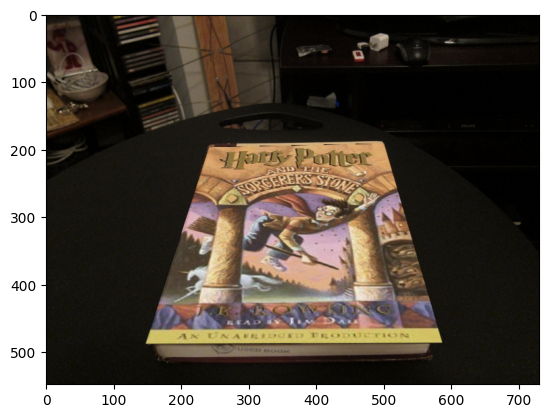

In [28]:
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0

# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

warpImage(ratio, sigma, max_iters, inlier_tol)

### Q2.2.5 (10 points):

Conduct ablation study with various max_iters and inlier_tol values. Plot the result images and explain the effect of these two parameters respectively.

In [29]:
# ===== your code here! =====
# Experiment with different max_iters and inlier_tol values.
# Include the result images in the write-up.
ratio = 0.7
sigma = 0.15
max_iters_1 = 600
inlier_tol_1 = 1.0

max_iters_2 = 700
inlier_tol_2 = 1.2

max_iters_3 = 800
inlier_tol_3 = 1.4

max_iters_4 = 900
inlier_tol_4 = 1.6

max_iters_5 = 1000
inlier_tol_5 = 1.8

max_iters_6 = 1100
inlier_tol_6 = 2.0

warpImage(ratio, sigma, max_iters_1, inlier_tol_1)
warpImage(ratio, sigma, max_iters_2, inlier_tol_2)
warpImage(ratio, sigma, max_iters_3, inlier_tol_3)
warpImage(ratio, sigma, max_iters_4, inlier_tol_4)
warpImage(ratio, sigma, max_iters_5, inlier_tol_5)
warpImage(ratio, sigma, max_iters_6, inlier_tol_6)
# ==== end of code ====

Output hidden; open in https://colab.research.google.com to view.

---

Explain the effect of max_iters and inlier_tol: \\
When increasing the `max_iters` and `inlier_tol`, we can see that the `hp_cover` can not fit well with the `cv_cover`. However, when `max_iters = 900` and `inliner_tol = 1.6`, the result show almost the same effect with the original parameter value.

---

# Q3 Create a Simple Panorama

## Q3.1 Create a panorama (10 points):

#### Implement the function createPanorama

In [30]:
def createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol):
    """
    Create a panorama augmented reality application by computing a homography
    and stitching together a left and right image.

    Input
    -----
    left_im: left image
    right_im: right image
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    panorama_im: Stitched together panorama

    """

    # ===== your code here! =====
    # TODO: match features between images
    # This can be done using matchPics, cpselect, or any other function.

    # TODO: Get homography by RANSAC using computeH_ransac

    # TODO: Stich together the two images
    # Requires the use of cv2.warpPerspective
    panorama_im = None

    matches, locs1, locs2 = matchPics(left_im, right_im, ratio, sigma)

    # Convert (row, col) to (x, y) for compatibility with OpenCV
    locs1 = locs1[:, [1, 0]]
    locs2 = locs2[:, [1, 0]]

    # Get matched locations
    matched_locs1 = locs1[matches[:, 0]]
    matched_locs2 = locs2[matches[:, 1]]

    # Compute the homography using RANSAC
    H2to1, _ = computeH_ransac(matched_locs1, matched_locs2, max_iters, inlier_tol)

    # Warp the right image to align with the left image
    output_shape = (left_im.shape[1] + right_im.shape[1], left_im.shape[0])
    panorama_im = cv2.warpPerspective(right_im, H2to1, output_shape)

    # Paste the left image onto the panorama
    panorama_im[0:left_im.shape[0], 0:left_im.shape[1]] = left_im

    # ==== end of code ====

    return panorama_im.astype(np.uint8)

#### Visualize Panorama

Make sure to use **your own images** and **include them as well as the result** in the report.

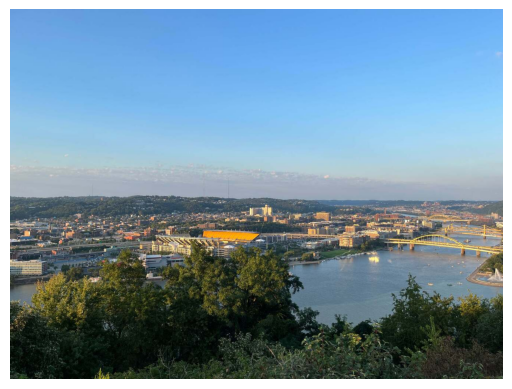

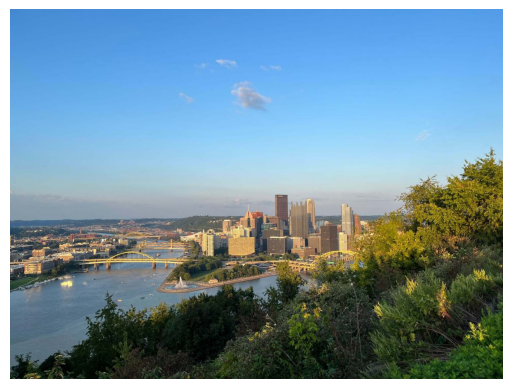

<ipython-input-8-93856fa3ecc0>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


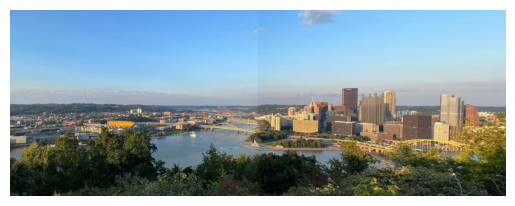

In [41]:
left_im_path = os.path.join(DATA_DIR, 'grand_view_left.jpg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, 'grand_view_right.jpg')
right_im = skimage.io.imread(right_im_path)

plt.imshow(left_im)
plt.axis('off')
plt.show()

plt.imshow(right_im)
plt.axis('off')
plt.show()

# Feel free to adjust as needed
ratio = 0.65
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

panorama_im = createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol)

plt.imshow(panorama_im)
# plt.imshow(left_im)
# plt.imshow(right_im)
plt.axis('off')
plt.show()